# ImageNet examples
Do all necessary imports:

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from skimage import io, color, segmentation, exposure
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

from CIU import CIU

2023-11-01 17:15:31.838185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load first test image:

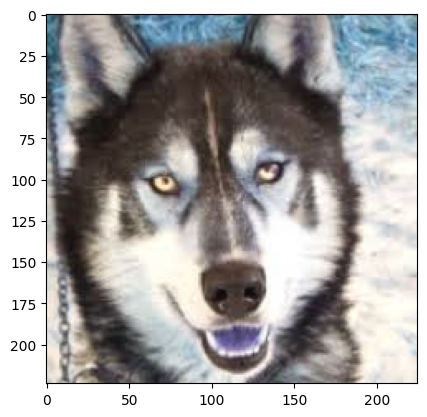

In [2]:
imgnames = ['HuskyAsWolf.jpg']
imgpath = "images/"
imgpaths = [imgpath + item for item in imgnames]

img = cv2.imread("images/HuskyAsWolf.jpg")
plt.imshow(img)
plt.show()

Those colours don't look right, so do the usual pre-processing and see what it looks like:

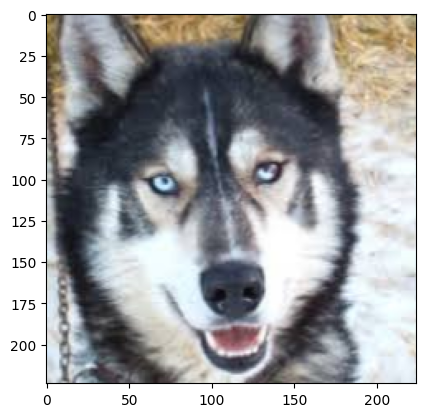

In [3]:
# This is a "standard" preprocessing for making images ImageNet compliant. 
def image_prep_ImageNet(image, size = (224, 224)):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, 3)
    img = img.reshape(-1, size[0], size[1], 3) # The model expects an array of images, so make it into one.
    return img

# Preprocess all images
imgs = []
for imgp in imgpaths:
    imgs.append(image_prep_ImageNet(cv2.imread(imgp)))
imgs_vstack = np.vstack(imgs)

# Plot all images
for img in imgs: 
    plt.imshow(img[0])
    plt.show()

In [4]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet')

# Predict the class of the image
preds = vgg16.predict(imgs)
decoded_preds = decode_predictions(preds, top=5)[0]  # Get the top 5 predictions

# Print the top predictions
for i, (imagenet_id, label, score) in enumerate(decoded_preds):
    print(f"{i + 1}: {label} ({score:.2%})")

1/1 [==============================] - 0s 296ms/step
1: Siberian_husky (55.94%)
2: Eskimo_dog (43.34%)
3: malamute (0.47%)
4: timber_wolf (0.07%)
5: white_wolf (0.05%)


Then some useful functions to be used here and there:

In [5]:
# Function for displaying array of images in a row.
def show_images_in_row(imgs, titles=("Image", "Segments", "Why?", "Why not?"), figsize=(8,8)):
    fig, axes = plt.subplots(1, len(imgs), figsize=figsize)
    for i in range(0,len(imgs)):
        axes[i].imshow(imgs[i])
        axes[i].axis('off')
        axes[i].set_title(titles[i])
    plt.tight_layout() # Adjust spacing between images
    plt.show()

## CIU explanation
We explore CIU values and explanation for one of the images, the Siberian husky (at least as given by VGG16 version of 1nov2023).

ChatGPT gives the following main characteristics for a Siberian husky that can be used for a picture of its head:

- **Appearance:**
Common coat colors include black, gray, red, and agouti, often with various facial markings and striking masks.

- **Eyes:**
One of the most distinctive features of Huskies is their captivating, almond-shaped, and often blue eyes.
Huskies can have eyes of different colors or even one eye of each color, a condition known as heterochromia.

- **Ears:**
Siberian Huskies have medium-sized, triangular ears that stand erect.

So we could expect that the model would use something about colours and facial markings, the eyes (even though they can be of different colors) and the ears.

In [6]:
img_to_xplain = 0 # Indices start from zero.
image = imgs_vstack[img_to_xplain]
ciu_vgg16 = CIU(vgg16, None)
tic = time.perf_counter()
ciu_sp_result = ciu_vgg16.Explain(image)
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")
# Display CI and CU values for "winning" class
winner = np.argmax(ciu_sp_result["outvals"])
print(f"CI values of winner class are:\n {ciu_sp_result['CI'][winner,:]}")
print(f"CU values of winner class are:\n {ciu_sp_result['CU'][winner,:]}")
print(f"Contextual influence values of winner class are:\n {ciu_sp_result['Cinfl'][winner,:]}")

Done in 2.5598 seconds
CI values of winner class are:
 [0.05275071 0.02722961 0.07421854 0.01456082 0.00859147 0.01754922
 0.01053452 0.00993806 0.01570499 0.1492992  0.01558912 0.00410956
 0.00205499 0.06090894 0.01793253 0.02844381 0.01224917 0.00943887
 0.03296912 0.00642669 0.01717252 0.00908607 0.02207863 0.00839281
 0.02654827 0.00558591 0.03423691 0.01667613 0.00095534 0.01682234
 0.00441533]
CU values of winner class are:
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1.]
Contextual influence values of winner class are:
 [ 0.02637535  0.0136148   0.03710927  0.00728041  0.00429574 -0.00877461
  0.00526726  0.00496903  0.00785249  0.0746496   0.00779456  0.00205478
  0.00102749  0.03045447  0.00896627  0.01422191  0.00612459 -0.00471944
  0.01648456  0.00321335 -0.00858626  0.00454304  0.01103932  0.00419641
  0.01327413  0.00279295  0.01711845 -0.00833806  0.00047767  0.00841117
  0.00220767]


A histogram plot is useful for determining what threshold value(s) to use. 

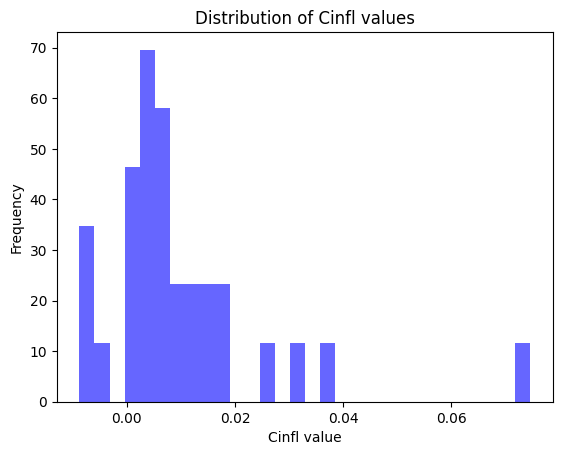

In [7]:
CIU_val = "Cinfl" # Cinfl, CI, CU, ...
vals = ciu_sp_result[CIU_val][winner,:]
plt.hist(vals, bins=30, density=True, alpha=0.6, color='b')
plt.xlabel(f'{CIU_val} value')
plt.ylabel('Frequency')
plt.title(f'Distribution of {CIU_val} values')
plt.show()

Now we go ahead with actual explanation. We include original image, image with segments indicated, the CIU "Why?" explanation and the CIU "Why not?" explanation.

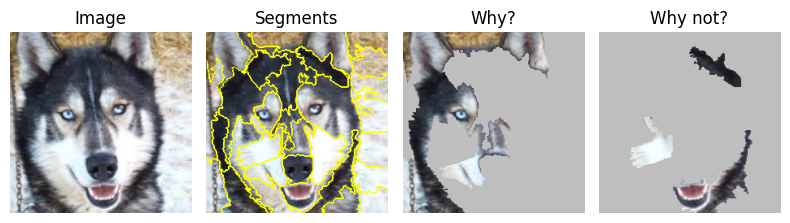

In [8]:
# Include at least one superpixel
max_val = ciu_sp_result[CIU_val][winner,:].max()
own_limit = 0.01
img_why = ciu_vgg16.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=min(max_val, own_limit))
img_whynot = ciu_vgg16.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=-0.001, type="whynot")
img_segments = segmentation.mark_boundaries(ciu_vgg16.original_image, ciu_vgg16.superpixels)
show_images_in_row([imgs_vstack[img_to_xplain],img_segments,img_why,img_whynot])

The "Why?" image shows that VGG16 presumably considers that the black facial marking is the most important feature, that the shape and colour of ears are significant and that the clear blue eye is significant. The grass background  just happens to be in the same superpixels as the ears.

The "Why not?" image shows the superpixels that are apparently not very typical for a Siberian husky but their inportance (and influence) are quite small on the classification. 

Just for "fun", below and alternative way of showing superpixels:

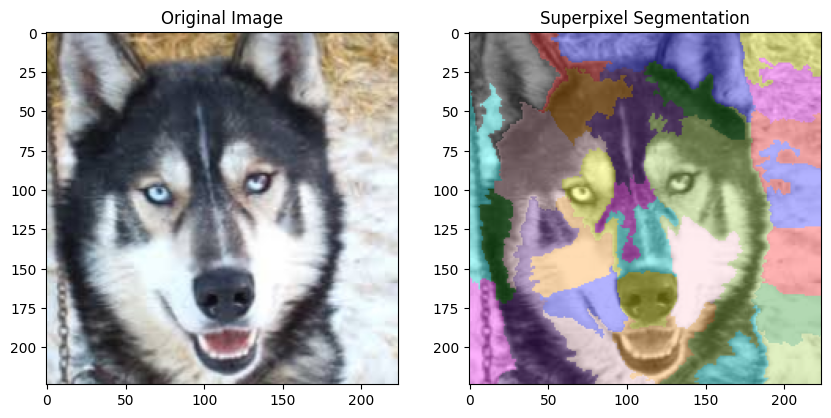

In [9]:
segmented_image = color.label2rgb(ciu_vgg16.superpixels, ciu_vgg16.original_image, kind='overlay') # or 'avg'
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(ciu_vgg16.original_image), plt.title('Original Image')
plt.subplot(122), plt.imshow(segmented_image), plt.title('Superpixel Segmentation')
plt.show()

## Resnet-152
We load the model and get the top classes.

**From now on we will use ResNet throughout this Notebook because VGG16 and ResNet apparently have incompatible image preprocessing!**

In [10]:
from keras.applications import ResNet152
from keras.applications.resnet import preprocess_input

# Load the ResNet-152 model with pre-trained weights on ImageNet
resnet_model = ResNet152(weights='imagenet')
predictions = resnet_model.predict(imgs_vstack)
decoded_predictions = decode_predictions(predictions, top=5)[0]
for _, label, confidence in decoded_predictions:
    print(f"{label}: {confidence:.2f}%")

1/1 [==============================] - 2s 2s/step
Siberian_husky: 0.71%
Eskimo_dog: 0.16%
Norwegian_elkhound: 0.05%
malamute: 0.02%
dingo: 0.01%


Then do CIU, display main CIU results and the histogram for selecting thresholds:

Done in 9.5183 seconds
CI values of winner class are:
 [0.00970608 0.00124669 0.0253253  0.00457776 0.00563228 0.08506012
 0.00480324 0.00926918 0.01075917 0.03738314 0.04898751 0.00823158
 0.01455981 0.11376548 0.03087407 0.02097923 0.04047137 0.06284618
 0.07893813 0.08795571 0.06733578 0.02293873 0.03734738 0.06295335
 0.01860559 0.00370437 0.02551526 0.03976482 0.00709361 0.04453844
 0.01094836]
CU values of winner class are:
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0.]
Cinfl values of winner class are:
 [-0.00485304 -0.00062335  0.01266265 -0.00228888 -0.00281614 -0.04253006
  0.00240162 -0.00463459  0.00537959  0.01869157 -0.02449375 -0.00411579
  0.0072799  -0.05688274 -0.01543704  0.01048961 -0.02023569 -0.03142309
 -0.03946906 -0.04397786 -0.03366789  0.01146936 -0.01867369  0.03147668
  0.00930279 -0.00185218 -0.01275763 -0.01988241 -0.0035468  -0.02226922
 -0.00547418]


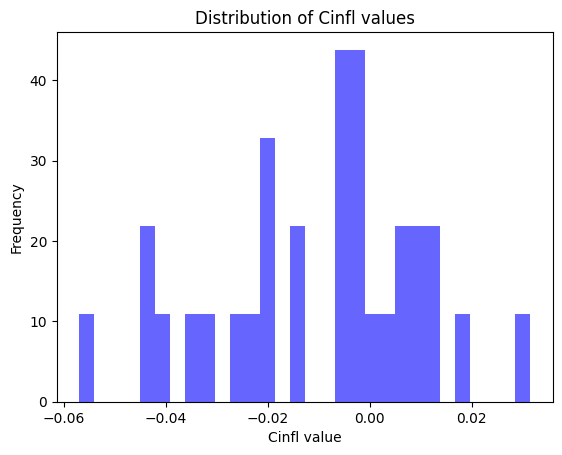

In [11]:
# CIU
ciu_resnet = CIU(resnet_model, None)
tic = time.perf_counter()
ciu_sp_result = ciu_resnet.Explain(image)
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")
# Display CI and CU values for "winning" class
winner = np.argmax(ciu_sp_result["outvals"])
print(f"CI values of winner class are:\n {ciu_sp_result['CI'][winner,:]}")
print(f"CU values of winner class are:\n {ciu_sp_result['CU'][winner,:]}")
print(f"Cinfl values of winner class are:\n {ciu_sp_result['Cinfl'][winner,:]}")
# Create and show histogram plot
CIU_val = "Cinfl" # Cinfl, CI, CU, ...
vals = ciu_sp_result[CIU_val][winner,:]
plt.hist(vals, bins=30, density=True, alpha=0.6, color='b')
plt.xlabel(f'{CIU_val} value')
plt.ylabel('Frequency')
plt.title(f'Distribution of {CIU_val} values')
plt.show()

Then the explanation images:

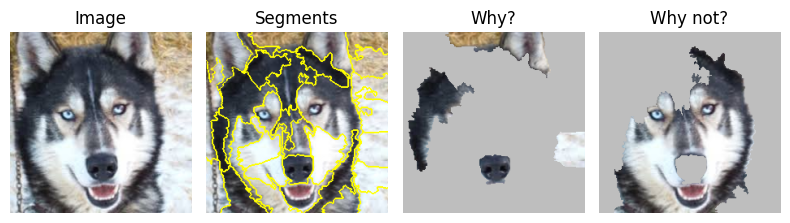

In [12]:
# Include at least one superpixel
max_val = ciu_sp_result[CIU_val][winner,:].max()
own_limit = 0.01
img_why = ciu_resnet.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=min(max_val, own_limit))
img_whynot = ciu_resnet.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=-0.01, type="whynot")
img_segments = segmentation.mark_boundaries(ciu_resnet.original_image, ciu_resnet.superpixels)
show_images_in_row([imgs_vstack[img_to_xplain],img_segments,img_why,img_whynot])

Apparently ResNet uses somewhat different criteria for identifying Siberian huskies than VGG16. However, here we have not considered joint effects and of different superpixels and their dependencies. CIU does that trough CIU's "intermediate concepts" that considers "coalitions of features", which in this case would signify different combinations of superpixels. This is ongoing research for the moment.

### How to choose good limit value for Contextual influence of CI?

Some sort of quantile approach could be good, as in the following code chunk. Alternatively, an interactive plot with a slider might be more intuitive and easy to use. To-be-done!

In [13]:
import pandas as pd
df = pd.Series(vals)

# Calculate the 75th percentile
median = df.quantile(0.75)
print("Median:", median)

Median: 0.00389060378074646


### Explaining the next-probability two classes

It is often interesting also to study why or why not the lower-probability classes would be eligible and why they have not been the "winners". 

The two next classes after Siberian husky are Eskimo dog (0.16\%) and Norwegian elkhound (0.05\%) (at least as given by ResNet152 version of 1nov2023). We explore CIU values and explanation for those two classes.

ChatGPT gives the following main characteristics for an **Eskimo dog** that can be used for a picture of its head:

- **Coat:** Fluffy, typically all white, although it can be biscuit or cream-colored.
- **Head:** Wedge-shaped.
- **Ears:** Pointed. 
- **Eyes:** Dark.

So we could expect that the model would focus on the white, fluffy coat as a positive indicator, whereas the eye colour should be a negative indicator, as well as the non-white ears even though they are pointed.

ChatGPT gives the following main characteristics for a **Norwegian elkhound** that can be used for a picture of its head:

- **Coat Color:** Typically gray, ranging from light silver to darker shades.
- **Head and Face:** Fox-like face with a wedge-shaped head. 
- **Eyes:** Dark brown.
- **Ears:** Pointed and stand erect. Their triangular shape is a notable feature.

So we could expect that the model would focus on the head shape and pointed, erect ears as positive indicators (if the colours are the expected ones). The eye colour is clearly a negative indicator.

CI values of class 248 are:
 [1.41769350e-02 2.74103731e-02 5.50055951e-02 1.25686824e-03
 5.62734902e-03 1.59774423e-02 1.16869390e-01 7.28874058e-02
 1.61501467e-02 1.23941362e-01 2.71786004e-02 2.20686197e-05
 1.01002604e-02 1.30942017e-02 2.99548507e-02 4.42444086e-02
 4.35292423e-02 2.93520093e-02 1.41425729e-02 2.92754769e-02
 2.56338716e-03 1.24664605e-02 3.65129784e-02 5.41871786e-03
 1.91553831e-02 1.00001842e-02 1.64339393e-02 1.32350028e-02
 4.23449576e-02 5.60554862e-03 9.66340303e-05]
CU values of class 248 are:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0.]
Cinfl values of class 248 are:
 [-7.08846748e-03 -1.37051865e-02 -2.75027975e-02  6.28434122e-04
 -2.81367451e-03 -7.98872113e-03 -5.84346950e-02 -3.64437029e-02
 -8.07507336e-03 -6.19706810e-02 -1.35893002e-02  1.10343099e-05
 -5.05013019e-03  6.54710084e-03 -1.49774253e-02 -2.21222043e-02
 -2.17646211e-02  1.46760046e-02  7.07128644e-03  1.46377385e-02
 -1.28169358e-0

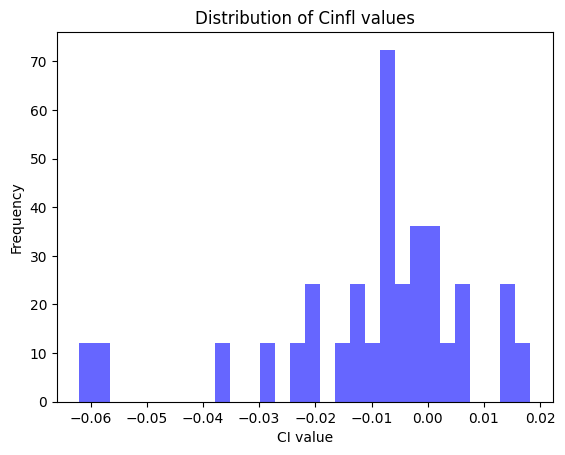

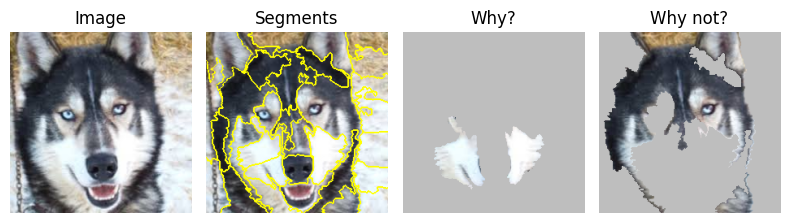

CI values of class 174 are:
 [0.00161454 0.01501981 0.0070087  0.0028309  0.00171747 0.04284403
 0.04943745 0.03813295 0.00327868 0.03853276 0.04214567 0.0014388
 0.01096646 0.04098218 0.04040713 0.00887651 0.04106821 0.02053066
 0.03454276 0.0225347  0.03467064 0.00297171 0.00515264 0.02895052
 0.00278718 0.01045614 0.02597958 0.00966125 0.02626286 0.02576423
 0.00759308]
CU values of class 174 are:
 [0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1.]
Cinfl values of class 174 are:
 [-0.00080727  0.00750991  0.00350435 -0.00141545  0.00085873  0.02142202
  0.02471873  0.01906647 -0.00163934  0.01926638  0.02107284  0.0007194
 -0.00548323  0.02049109  0.02020357  0.00443825  0.02053411  0.01026533
  0.01727138  0.01126735  0.01733532 -0.00148585  0.00257632 -0.01447526
  0.00139359  0.00522807  0.01298979  0.00483062  0.01313143  0.01288211
  0.00379654]


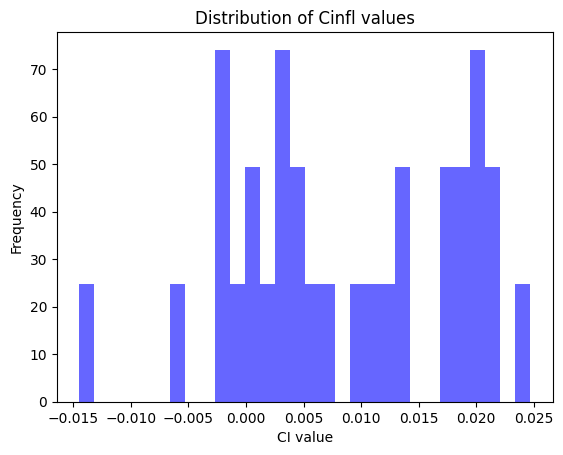

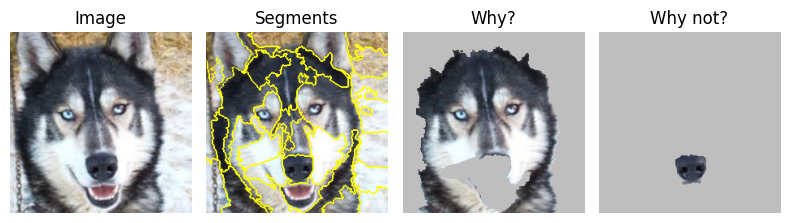

In [14]:
# Get explanations for the next two classes too.
outvals = ciu_sp_result["outvals"][0]
class_ranking = sorted(range(len(outvals)), key=lambda i: outvals[i], reverse=True)
nbr_classes = 2
for i in range(1,nbr_classes+1):
    ind = class_ranking[i]
    vals = ciu_sp_result['Cinfl'][ind,:]
    print(f"CI values of class {ind} are:\n {ciu_sp_result['CI'][ind,:]}")
    print(f"CU values of class {ind} are:\n {ciu_sp_result['CU'][ind,:]}")
    print(f"Cinfl values of class {ind} are:\n {ciu_sp_result['Cinfl'][ind,:]}")
    plt.hist(vals, bins=30, density=True, alpha=0.6, color='b')
    plt.xlabel('CInfl value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cinfl values')
    plt.show()
    max_val = vals.max()
    own_limit = 0.01
    img_why = ciu_resnet.ImageInfluentialSegmentsOnly(ind, Cinfl_limit=min(max_val, own_limit))
    img_whynot = ciu_resnet.ImageInfluentialSegmentsOnly(ind, Cinfl_limit=-0.01, type="whynot")
    img_segments = segmentation.mark_boundaries(ciu_resnet.original_image, ciu_resnet.superpixels)
    show_images_in_row([imgs_vstack[img_to_xplain],img_segments,img_why,img_whynot])

Indeed, as expected the *Eskimo dog* explanation focuses on the fluffy white fur parts. 

For the *Norwegian elkhound* the interpretation becomes more complex because almost the whole head is included, which might be due to the head shape (that presumably overrides the wrong eye colour). The ear shape would normally have a positive influence but when looking at photos of Norwegian elkhounds, it becomes clear that the ear colors are not at all the right ones. Apparently the nose, mouth and white fur around them has a negative influence. It's a little surprising that the nose has the greatest negative influence but that is presumably somehow due to a dependency with other superpixels. 

## Some more images

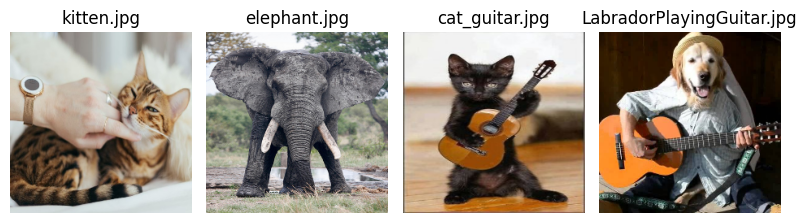

In [15]:
imgnames = ["kitten.jpg","elephant.jpg","cat_guitar.jpg","LabradorPlayingGuitar.jpg"]
imgpath = "images/"
imgpaths = [imgpath + item for item in imgnames]

# Preprocess all images
imgs = []
for imgp in imgpaths:
    imgs.append(image_prep_ImageNet(cv2.imread(imgp)))
imgs_vstack = np.vstack(imgs)

# Plot all images
fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(8, 8))
for i in range(0,len(imgs)): 
    axes[i].imshow(imgs_vstack[i])
    axes[i].axis('off')
    axes[i].set_title(imgnames[i])
plt.tight_layout() # Adjust spacing between images
plt.show()

1/1 [==============================] - 0s 238ms/step
1: tiger_cat (37.01%)
2: tabby (32.70%)
3: Egyptian_cat (21.46%)
4: washer (1.68%)
5: shower_curtain (1.40%)
CI values of winner class are:
 [0.02541265 0.01584828 0.04582912 0.06484348 0.03341398 0.01729587
 0.01680517 0.00994918 0.22712636 0.02292359 0.05827868 0.05919299
 0.18715012 0.09124359 0.02401069 0.00760555 0.04440269 0.07369435
 0.28391243 0.24669682 0.00491077 0.01975462 0.15639865 0.29285784
 0.05531502 0.14085793 0.0339011  0.35131725 0.06476313 0.12064408
 0.0599376  0.37524682 0.16424531 0.10907769 0.01841137 0.01633674]
CU values of winner class are:
 [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
Cinfl values of winner class are:
 [ 0.01270632  0.00792414 -0.02291456  0.03242174 -0.01670699  0.00864793
  0.00840259  0.00497459 -0.11356318  0.01146179 -0.02913934 -0.02959649
 -0.09357506 -0.0456218  -0.01200534 -0.00380278 -0.02220134 -0.03684717
  0.14

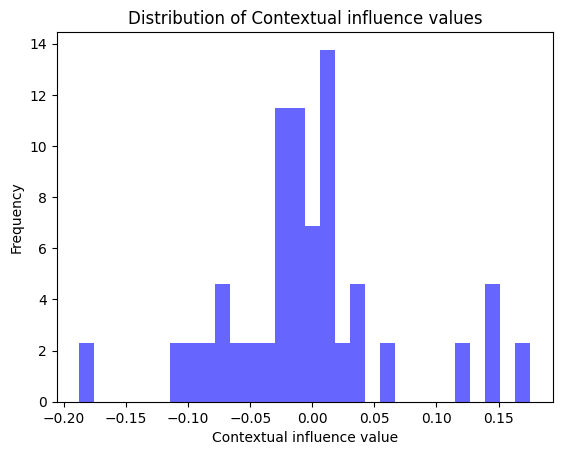

In [18]:
img_index = 0
model = resnet_model
ciu = ciu_resnet

# Predict the class of the image
preds = model.predict(imgs[img_index])
decoded_preds = decode_predictions(preds, top=5)[0]  # Get the top 5 predictions

# Print the top predictions
for i, (imagenet_id, label, score) in enumerate(decoded_preds):
    print(f"{i + 1}: {label} ({score:.2%})")
    
# Run CIU
tic = time.perf_counter()
ciu_sp_result = ciu.Explain(imgs_vstack[img_index])
winner = np.argmax(ciu_sp_result["outvals"])
print(f"CI values of winner class are:\n {ciu_sp_result['CI'][winner,:]}")
print(f"CU values of winner class are:\n {ciu_sp_result['CU'][winner,:]}")
print(f"Cinfl values of winner class are:\n {ciu_sp_result['Cinfl'][winner,:]}")

# Create and show histogram plot
vals = ciu_sp_result["Cinfl"][winner,:]
plt.hist(vals, bins=30, density=True, alpha=0.6, color='b')
plt.xlabel('Contextual influence value')
plt.ylabel('Frequency')
plt.title('Distribution of Contextual influence values')
plt.show()

The image is kitten.jpg


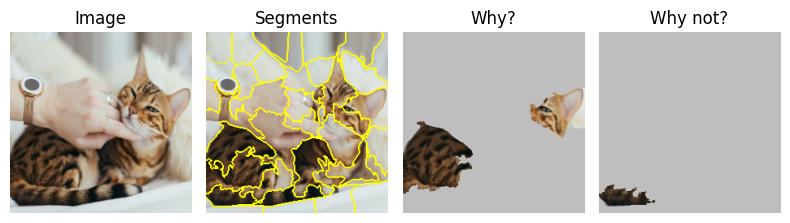

In [19]:
# Plot image and explanation
print(f"The image is {imgnames[img_index]}")
max_val = vals.max()
own_limit = 0.1
img_why = ciu.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=min(max_val, own_limit))
img_whynot = ciu.ImageInfluentialSegmentsOnly(winner, Cinfl_limit=-0.15, type="whynot")
img_segments = segmentation.mark_boundaries(ciu.original_image, ciu.superpixels)
show_images_in_row([imgs_vstack[img_index],img_segments,img_why,img_whynot])